In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import datetime

IndexError: too many indices for array

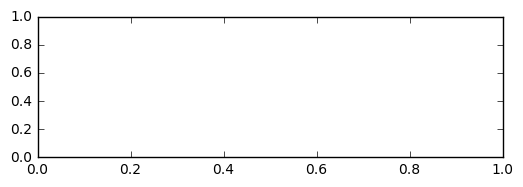

In [2]:
# get data location
data_path = os.environ['DATA_PATH'] #Temporary, while I work on local computer. For actual github instantion, use: data_path = os.environ['DATA_PATH']
OUT_DAY = 'arr_day.npy' #the output files containing integrated power and metadata for each sweep-spectrum on record
OUT_NIGHT = 'arr_night.npy'

arr_day=np.load(OUT_DAY) # content: [datetime.datetime obj], [float(integrated power)]
arr_night=np.load(OUT_NIGHT)

arr_full_day = np.concatenate((np.array(arr_day), np.array(arr_night)),axis=0)

plt.figure(1)
plt.subplot(211)
plt.plot(arr_day[:,0], arr_day[:,1],'bo')
plt.plot(arr_night[:,0], arr_night[:,1],'go')
plt.subplot(211).set_title(str('Daytime ('+str(delta_hour)+' Hours, '+str(delta_minute)+' Minutes) Integrated Power: '+str(  np.round(sum_array_of_dbm(arr_day[:,1]),decimals=1) )+ 'dBm, Nighttime Integrated Power: '+str(  np.round(sum_array_of_dbm(arr_night[:,1]),decimals=1)  )+' dBm'))
plt.subplot(212)
plt.plot(arr_full_day[:,0], arr_full_day[:,1],'ro')
plt.subplot(212).set_title(str('Full 24 Hours, Average Integrated Power: ' + str(  np.round(sum_array_of_dbm(arr_full_day[:,1]),decimals=1)  )+' dBm'))

plt.show()